## Setup

In [1]:
# Global packages
import pandas as pd
from datetime import datetime
from joblib import delayed, Parallel

In [2]:
# Global variables
from datetime import timedelta
now = datetime.now()
SINCE = (now - timedelta(days=7)).strftime("%Y-%m-%d")
UNTIL = now.strftime("%Y-%m-%d")

## Get stock data

In [3]:
# Define IDs
ids = {
    "IBOV": "941612",
    "PETR": "18750"
}

In [4]:
import requests

for ticker, id in ids.items():

    # Request data
    response = requests.post(
        "https://br.investing.com/instruments/HistoricalDataAjax",
        {
            "st_date": datetime.strptime(SINCE, "%Y-%m-%d").strftime("%d/%m/%Y"),
            "end_date": "01/01/2030",
            "interval_sec": "Daily",
            "curr_id": id
        },
        headers={"User-Agent": "Mozilla/5.0", "X-Requested-With": "XMLHttpRequest"}
    )
    dataframe = pd.read_html(response.text)[0]

    # Save data
    dataframe.to_csv(f"quotations_{ticker}.csv", index=False)

In [5]:
dataframe.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,22.10.2020,2084,2010,2084,2005,"95,57M","3,53%"
1,21.10.2020,2013,2016,2033,1983,"56,96M","-0,25%"
2,20.10.2020,2018,1968,2027,1959,"66,61M","3,38%"
3,19.10.2020,1952,1941,1993,1925,"107,22M","0,98%"
4,16.10.2020,1933,1962,1970,1932,"47,31M","-2,13%"


## Get Twitter data

In [6]:
# Define searches
searches = {
    "PETR": ["petrobras", "#petr", "#petr3", "#petr4"]
}

In [7]:
# Initiate API
import twitter

api = twitter.Api(
    consumer_key="RDQls1qlqi9YyFwpSwDW7IQDF",
    consumer_secret="BK03OmwGFjPEf2cHcxRdd0h6kIHul0luFwleEab5GIGicxxsHz",
    access_token_key="1207468063886630914-c7swEk9Fq1V6xOaduReBIUGpxZExIF",
    access_token_secret="iUdZjKMPRIfW4mHpOtTYjZ8HR76ICci4NCBohOIw2mNkk",
    tweet_mode="extended"
)

In [8]:
import time
from urllib.parse import quote

for ticker, words in searches.items():
    tweets = []
    max_id = None

    # Request data
    for i in range(500000):
        try:
            response = api.GetSearch(
                term="%20OR%20".join(words),
                since=SINCE,
                until=UNTIL,
                lang="pt",
                return_json=True,
                count=100,
                result_type="recent",
                max_id=max_id
            )
        except Exception as error:
            print(f"{i}: {error}")
            time.sleep(60 * 15)
            continue

        # Select tweets
        for item in response["statuses"]:
            if "retweeted_status" not in item and item["in_reply_to_status_id"] is None:
                tweets.append({
                    "created_at": item["created_at"],
                    "id": item["id"],
                    "text": item["full_text"],
                    "retweet_count": item["retweet_count"],
                    "favorite_count": item["favorite_count"],
                })

        # Update ID
        if len(response["statuses"]) == 0:
            break
        max_id = response["statuses"][-1]["id"] - 1

    # Save data
    dataframe = pd.DataFrame(tweets)
    dataframe.to_csv(f"tweets_{ticker}.csv", index=False)

In [9]:
dataframe.head()

,created_at,id,text,retweet_count,favorite_count
0,Wed Oct 21 23:59:01 +0000 2020,1319065685063073794,STF inicia julgamento sobre ICMS de gás import...,0,4
1,Wed Oct 21 23:52:40 +0000 2020,1319064089004564482,Drinking a Flor de Hibisco by Hop Capital Beer...,0,0
2,Wed Oct 21 23:52:07 +0000 2020,1319063949761970177,Vagabundo do Augusto Nunes acabou de dizer na ...,0,1
3,Wed Oct 21 23:51:27 +0000 2020,1319063783956975618,Os ataques à Petrobras são uma falácia do Nest...,0,0
4,Wed Oct 21 23:40:31 +0000 2020,1319061033000947714,Bolsonaro vai sugerir que Petrobras destine re...,8,88


## Load data

In [10]:
tweets = pd.read_csv("tweets_PETR.csv")
quotations = pd.read_csv("quotations_PETR.csv")
benchmark = pd.read_csv("quotations_IBOV.csv")

## Perform sentiment analysis

In [11]:
from googletrans import Translator

def translate(text):
    N_TRIES = 3
    for i in range(N_TRIES):
        try:
            translator = Translator()
            translation = translator.translate(text, src="pt", dest="en")
            translation = translation.text
            break
        except Exception:
            if i+1 == N_TRIES:
                translation = "error"
    return translation

tweets["translation"] = Parallel(n_jobs=-1, verbose=10)(
    delayed(translate)(text) for text in tweets["text"]
)

if len(tweets[tweets["translation"] == "error"]):
    raise Exception("There are errors on the translations!")
    
tweets.head()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   

,created_at,id,text,retweet_count,favorite_count,translation
0,Wed Oct 21 23:59:01 +0000 2020,1319065685063073794,STF inicia julgamento sobre ICMS de gás import...,0,4,STF starts judgment on ICMS for gas imported f...
1,Wed Oct 21 23:52:40 +0000 2020,1319064089004564482,Drinking a Flor de Hibisco by Hop Capital Beer...,0,0,Drinking a Hibiscus Flower by Hop Capital Beer...
2,Wed Oct 21 23:52:07 +0000 2020,1319063949761970177,Vagabundo do Augusto Nunes acabou de dizer na ...,0,1,Vagabundo do Augusto Nunes just said in Record...
3,Wed Oct 21 23:51:27 +0000 2020,1319063783956975618,Os ataques à Petrobras são uma falácia do Nest...,0,0,The attacks on Petrobras are a fallacy of Nest...
4,Wed Oct 21 23:40:31 +0000 2020,1319061033000947714,Bolsonaro vai sugerir que Petrobras destine re...,8,88,Bolsonaro will suggest that Petrobras allocate...


In [12]:
# Get sentiment
from flair.models import TextClassifier
from flair.data import Sentence

model = TextClassifier.load("en-sentiment")
def get_sentiment(text):
    sentence = Sentence(text)
    model.predict(sentence)
    label = sentence.labels[0]
    sentiment = label.score
    if label.value == "NEGATIVE":
        sentiment = -1 * sentiment
    return sentiment

tweets["sentiment"] = Parallel(n_jobs=-1, verbose=10)(
    delayed(get_sentiment)(text) for text in tweets["translation"]
)
        
tweets.head()

2020-10-22 19:44:15,841 loading file /Users/luizmanke/.flair/models/sentiment-en-mix-distillbert_3.1.pt


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   42.4s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   53.9s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  4

,created_at,id,text,retweet_count,favorite_count,translation,sentiment
0,Wed Oct 21 23:59:01 +0000 2020,1319065685063073794,STF inicia julgamento sobre ICMS de gás import...,0,4,STF starts judgment on ICMS for gas imported f...,-0.930202
1,Wed Oct 21 23:52:40 +0000 2020,1319064089004564482,Drinking a Flor de Hibisco by Hop Capital Beer...,0,0,Drinking a Hibiscus Flower by Hop Capital Beer...,-0.512647
2,Wed Oct 21 23:52:07 +0000 2020,1319063949761970177,Vagabundo do Augusto Nunes acabou de dizer na ...,0,1,Vagabundo do Augusto Nunes just said in Record...,-0.945891
3,Wed Oct 21 23:51:27 +0000 2020,1319063783956975618,Os ataques à Petrobras são uma falácia do Nest...,0,0,The attacks on Petrobras are a fallacy of Nest...,-0.992095
4,Wed Oct 21 23:40:31 +0000 2020,1319061033000947714,Bolsonaro vai sugerir que Petrobras destine re...,8,88,Bolsonaro will suggest that Petrobras allocate...,-0.986373


## Exploratory analysis

In [13]:
# Most positive
tweets.sort_values("sentiment", ascending=False).head()

,created_at,id,text,retweet_count,favorite_count,translation,sentiment
1437,Fri Oct 16 21:46:46 +0000 2020,1317220466898120705,Ficou com Lucas Foresti o Troféu Melhor Ultrap...,0,4,Lucas Foresti won the Best Overtaking Trophy o...,0.999933
197,Wed Oct 21 13:02:56 +0000 2020,1318900580060962817,"se tem o lacre verde da br petrobras, pode con...",0,0,"if you have the green seal from br petrobras, ...",0.999931
1338,Sat Oct 17 13:19:36 +0000 2020,1317455222889906176,E deu dobradinha da Blau no último treino livr...,3,20,"And he doubled Blau in the last free practice,...",0.999927
239,Wed Oct 21 11:41:49 +0000 2020,1318880166299553792,https://t.co/92lLb7bG4a\nPetrobras atinge prod...,0,0,https://t.co/92lLb7bG4a\nPetrobras achieves oi...,0.999888
512,Tue Oct 20 17:18:42 +0000 2020,1318602558101884929,Allam Khodair estava on fire no Velocitta e fe...,0,11,Allam Khodair was on fire at Velocitta and mad...,0.999883


In [14]:
# Most negative
tweets.sort_values("sentiment", ascending=True).head()

,created_at,id,text,retweet_count,favorite_count,translation,sentiment
1263,Sat Oct 17 22:00:28 +0000 2020,1317586300388737025,nem acho o prédio da Petrobrás tão feio assim!...,0,3,I don't even think the Petrobras building is s...,-0.999998
1228,Sun Oct 18 01:19:13 +0000 2020,1317636317652619265,O prédio da Petrobras (esse último aí) é uma d...,1,1,The Petrobras building (the latter one) is one...,-0.999998
1283,Sat Oct 17 19:52:01 +0000 2020,1317553976813015041,Muito do que o desgoverno do coiso está promov...,0,0,Much of what the mismanagement of the thing is...,-0.999997
211,Wed Oct 21 12:43:37 +0000 2020,1318895719055609864,Vamos ver o IQ de #PETR4? A coisa está estranh...,1,8,Let's see the IQ of # PETR4? The thing is stra...,-0.999997
1327,Sat Oct 17 15:18:21 +0000 2020,1317485105544417281,"o da petrobrás eu acho horrível, sempre que pa...",0,1,"the one from petrobrás i think it's horrible, ...",-0.999995


In [15]:
# Most retweeted
tweets.sort_values("retweet_count", ascending=False).head()

,created_at,id,text,retweet_count,favorite_count,translation,sentiment
850,Tue Oct 20 10:26:53 +0000 2020,1318498920432078848,URGENTE: Polícia Federal está neste momento cu...,3041,10513,URGENT: The Federal Police is currently execut...,0.751506
417,Tue Oct 20 21:32:45 +0000 2020,1318666490669912064,UM CRIME CONTRA O BRASIL\nDilma diz que o desm...,764,3719,A CRIME AGAINST BRAZIL\nDilma says that the di...,-0.997450
626,Tue Oct 20 13:42:52 +0000 2020,1318548240787267588,"A PF, em conjunto com o @MPF_PGR e @ReceitaFed...",243,928,"The PF, in conjunction with @MPF_PGR and @Rece...",0.778986
170,Wed Oct 21 14:36:50 +0000 2020,1318924210975145984,"VEJA E A PIADA DO DIA\n""Dilma acusa Bolsonaro ...",240,1022,"SEE AND THE JOKE OF THE DAY\n""Dilma accuses Bo...",-0.998772
163,Wed Oct 21 14:44:28 +0000 2020,1318926131035361282,Consegue adivinhar quantos barris extraímos po...,222,2777,Can you guess how many barrels we extract per ...,0.685268


In [16]:
# Most favorited
tweets.sort_values("favorite_count", ascending=False).head()

,created_at,id,text,retweet_count,favorite_count,translation,sentiment
850,Tue Oct 20 10:26:53 +0000 2020,1318498920432078848,URGENTE: Polícia Federal está neste momento cu...,3041,10513,URGENT: The Federal Police is currently execut...,0.751506
417,Tue Oct 20 21:32:45 +0000 2020,1318666490669912064,UM CRIME CONTRA O BRASIL\nDilma diz que o desm...,764,3719,A CRIME AGAINST BRAZIL\nDilma says that the di...,-0.997450
163,Wed Oct 21 14:44:28 +0000 2020,1318926131035361282,Consegue adivinhar quantos barris extraímos po...,222,2777,Can you guess how many barrels we extract per ...,0.685268
1218,Sun Oct 18 03:04:31 +0000 2020,1317662819064664065,DESDE O CLÁSSICO P.T. X PETROBRÁS EU NÃO VIA U...,171,1588,SINCE CLASSIC P.T. X PETROBRÁS I DIDN'T SEE A ...,0.877226
170,Wed Oct 21 14:36:50 +0000 2020,1318924210975145984,"VEJA E A PIADA DO DIA\n""Dilma acusa Bolsonaro ...",240,1022,"SEE AND THE JOKE OF THE DAY\n""Dilma accuses Bo...",-0.998772


/Users/luizmanke/Desktop/Projects/stock-sentiment-analysis/env/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:1088: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


<AxesSubplot:xlabel='created_at'>

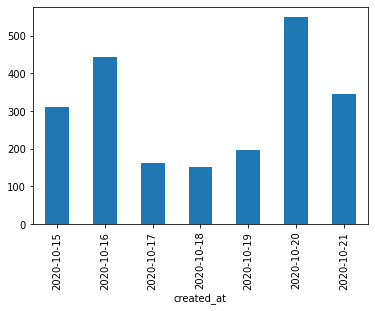

In [17]:
# Number of tweets per day
df_copy = tweets.copy()
df_copy["count"] = 1
df_copy["created_at"] = pd.to_datetime(df_copy["created_at"])
df_copy["count"].groupby(df_copy["created_at"].dt.to_period("D")).sum().plot(kind="bar")

<AxesSubplot:xlabel='Data'>

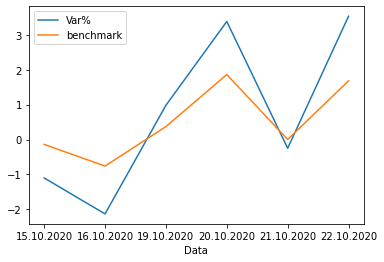

In [18]:
# Quotation variations
dataframe = quotations.set_index("Data")
dataframe["Var%"] = [string.replace(",", ".").replace("%", "") for string in dataframe["Var%"]]
dataframe["benchmark"] = [string.replace(",", ".").replace("%", "") for string in benchmark["Var%"]]
dataframe = dataframe.sort_index()
dataframe[["Var%", "benchmark"]].astype(float).plot()